In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('NSE-TATAGLOBAL.csv')
training_set = dataset_train.iloc[:, 1:2].values


In [3]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


Using TensorFlow backend.


In [8]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [9]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


In [10]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [11]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [12]:
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1975/1975 [==============================] - 18s 9ms/step - loss: 0.0139
Epoch 2/100
1975/1975 [==============================] - 16s 8ms/step - loss: 0.0029
Epoch 3/100
1975/1975 [==============================] - 14s 7ms/step - loss: 0.0028
Epoch 4/100
1975/1975 [==============================] - 16s 8ms/step - loss: 0.0024
Epoch 5/100
1975/1975 [==============================] - 16s 8ms/step - loss: 0.0024
Epoch 6/100
1975/1975 [==============================] - 15s 8ms/step - loss: 0.0025
Epoch 7/100
1975/1975 [==============================] - 15s 8ms/step - loss: 0.0023
Epoch 8/100
1975/1975 [==============================] - 15s 8ms/step - loss: 0.0018
Epoch 9/100
1975/1975 [==============================] - 15s 8ms/step - loss: 0.0019
Epoch 10/100
1975/1975 [==============================] - 15s 8ms/step - loss: 0.0020
Epoch 11/100
1975/1975 [==============================] - 15s 8ms/step - loss: 0.0019
Epoch 12/100
1975/1975 [==============================] - 15s 8

In [13]:
dataset_test = pd.read_csv('tatatest.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [14]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [81]:
pred_arr = predicted_stock_price.ravel()
pred_series = pd.Series(pred_arr)
pred_series = pred_series.to_frame()
pred_series.columns = ['Price']
pred_series['Signal'] = np.where (pred_series['Price'].shift(-1) > pred_series['Price'],1,0)

real_arr = real_stock_price.ravel()
real_series = pd.Series(real_arr)
real_series = real_series.to_frame()
real_series.columns = ['Price']
real_series['Signal'] = np.where (real_series['Price'].shift(-1) > real_series['Price'],1,0)

y_pred = pred_series['Signal'].values
y_test = real_series['Signal'].values



In [78]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))



[[5 2]
 [2 7]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.78      0.78      0.78         9

   micro avg       0.75      0.75      0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16



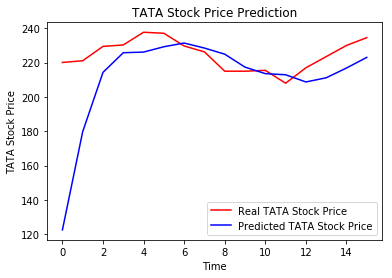

In [79]:
plt.plot(real_stock_price, color = 'red', label = 'Real TATA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()